## Functions

In [1]:
!pip install -q xgboost datasets matplotlib joblib scikit-learn scipy 

In [87]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [2]:
from utils import preprocess_raw_data, add_time_features, prepare_model_features, train_location_model, make_predictions

# 2. INFERENCE


### 2.1 Download the data


In [89]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta
import hopsworks
import os

In [90]:
# Hopsworks setup
os.environ["HOPSWORKS_API_KEY"] = "pJymTzms8OtLxz9l.fj2klQnbFO3ZmkYrgeAGMEAKguhmEYo3wcmb6rDXd3NRJu1Xv9WNDGAUj4TFgh3Z"
project = hopsworks.login()
fs = project.get_feature_store()

# Get or create feature group
feature_group = fs.get_or_create_feature_group(
    name='kth_seating_percentage',
    description='Time-based occupancy data',
    version=1,
    primary_key=['id'],
    event_time=['time'],
    online_enabled=True
)


2025-01-07 10:03:50,040 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 10:03:50,054 INFO: Initializing external client
2025-01-07 10:03:50,055 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 10:03:51,353 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1205426


In [91]:
# Load existing data
df_seating = feature_group.read()
df_seating = df_seating.sort_values(by='time', ascending=True)
df_seating

if 'id' in df_seating.columns:
    df_seating.set_index('id', inplace=True)
    
df_seating['time'] = df_seating['time'].dt.tz_localize(None)
#df_seating.drop(['id'], axis = 1, inplace = True) 
df_seating.set_index('time', inplace=True)

df_seating

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,kth_library,south_east_gallery,north_gallery,south_gallery,angdomen,newton
time,,,,,,
2024-12-09 18:16:16,35,66,60,17,21,22
2024-12-09 18:19:24,34,66,59,14,19,22
2024-12-09 18:22:31,32,69,59,17,18,22
2024-12-09 18:25:37,29,66,56,26,19,22
2024-12-09 18:28:44,29,71,56,26,19,17
...,...,...,...,...,...,...
2025-01-07 06:38:30,0,0,0,0,0,0
2025-01-07 07:10:45,7,2,9,6,1,0
2025-01-07 07:42:59,14,0,30,11,7,0


In [92]:
# Rename the columns as specified
df_seating.rename(columns={
    'kth_library': 'KTH Library',
    'south_east_gallery': 'South-East Gallery',
    'north_gallery': 'North Gallery',
    'south_gallery': 'South Gallery',
    'angdomen': 'Angdomen',
    'newton': 'Newton'
}, inplace=True)

# Display the DataFrame to verify the changes
df_seating

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton
time,,,,,,
2024-12-09 18:16:16,35,66,60,17,21,22
2024-12-09 18:19:24,34,66,59,14,19,22
2024-12-09 18:22:31,32,69,59,17,18,22
2024-12-09 18:25:37,29,66,56,26,19,22
2024-12-09 18:28:44,29,71,56,26,19,17
...,...,...,...,...,...,...
2025-01-07 06:38:30,0,0,0,0,0,0
2025-01-07 07:10:45,7,2,9,6,1,0
2025-01-07 07:42:59,14,0,30,11,7,0


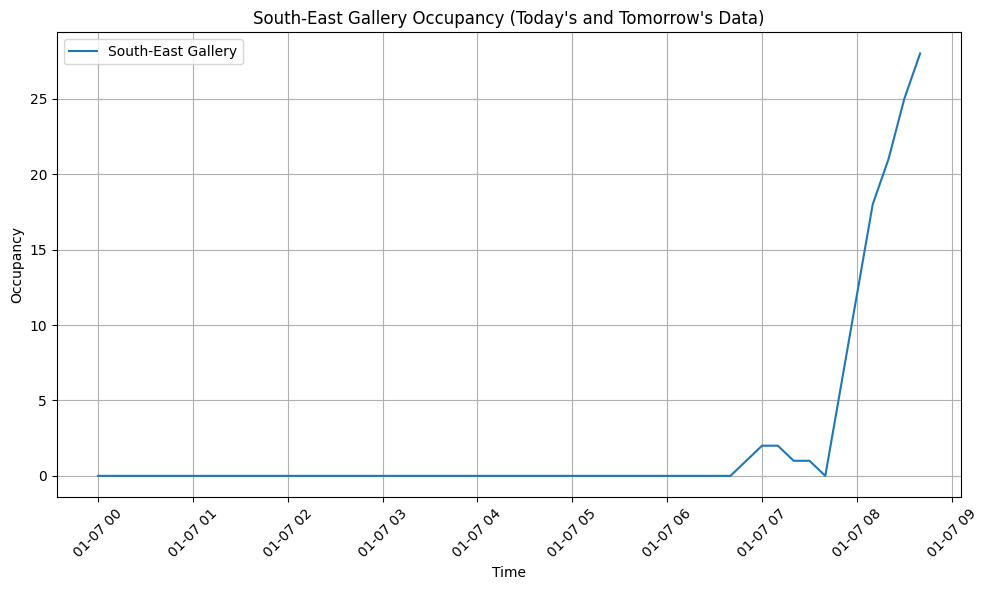

Downloaded Data (without NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-07 08:00:00         23.0                12.0           43.0   
2025-01-07 08:10:00         27.0                18.0           49.0   
2025-01-07 08:20:00         33.0                21.0           56.0   
2025-01-07 08:30:00         38.0                25.0           64.0   
2025-01-07 08:40:00         44.0                28.0           71.0   

                     South Gallery  Angdomen  Newton  
2025-01-07 08:00:00           19.0       9.0     7.0  
2025-01-07 08:10:00           23.0      10.0    11.0  
2025-01-07 08:20:00           25.0      12.0    18.0  
2025-01-07 08:30:00           27.0      14.0    26.0  
2025-01-07 08:40:00           29.0      16.0    33.0  

Null Data (with NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-07 08:50:00          NaN                 NaN            NaN   
2025-01-07 09:00:00          NaN               

In [93]:
# Resample to 10-minute intervals and fill missing data (while keeping original rounding)
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)

# Filter data to only include today and tomorrow
today = pd.Timestamp.today().normalize()  # Today's date without time
tomorrow_midnight = (today + timedelta(days=1)).normalize()  # Tomorrow's midnight
end_of_tomorrow = tomorrow_midnight + timedelta(days=1)  # End of tomorrow, for the full 24 hours

# Get the last available entry for today
last_valid_entry = df_seating_resampled[df_seating_resampled.index.date == today.date()].index[-1]

# Create the datetime range from the last entry until tomorrow midnight
time_range = pd.date_range(start=last_valid_entry + timedelta(minutes=10), end=end_of_tomorrow, freq='10T')

# Create a DataFrame for this time range with NaN values
nan_df = pd.DataFrame(np.nan, index=time_range, columns=df_seating_resampled.columns)

# Concatenate the original data with the NaN data (after the last valid entry until tomorrow midnight)
df_seating_combined = pd.concat([df_seating_resampled, nan_df])

# Ensure the data has the correct format, with NaN entries for after today until tomorrow midnight
df_seating_combined = df_seating_combined.sort_index()

# Filter to keep only data from today and tomorrow
df_today_tomorrow = df_seating_combined[(df_seating_combined.index >= today) & (df_seating_combined.index < end_of_tomorrow)]

# Split into downloaded data (non-NaN) and null data (NaN)
df_downloaded = df_today_tomorrow[df_today_tomorrow.notna().all(axis=1)].copy()
df_null = df_today_tomorrow[df_today_tomorrow.isna().any(axis=1)].copy()

# Recombine into the full DataFrame
df_full = pd.concat([df_downloaded, df_null]).sort_index()

# Plot the data for today and tomorrow
plt.figure(figsize=(10, 6))
plt.plot(df_full.index, df_full['South-East Gallery'], label="South-East Gallery")
plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, print the split DataFrames to check
print("Downloaded Data (without NaN):")
print(df_downloaded.tail())

print("\nNull Data (with NaN):")
print(df_null.head())

#print("\nFull DataFrame after recombination:")
#print(df_full)

In [94]:
df_downloaded.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton
2025-01-07 08:00:00,23.0,12.0,43.0,19.0,9.0,7.0
2025-01-07 08:10:00,27.0,18.0,49.0,23.0,10.0,11.0
2025-01-07 08:20:00,33.0,21.0,56.0,25.0,12.0,18.0
2025-01-07 08:30:00,38.0,25.0,64.0,27.0,14.0,26.0
2025-01-07 08:40:00,44.0,28.0,71.0,29.0,16.0,33.0


In [95]:
df_null.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN


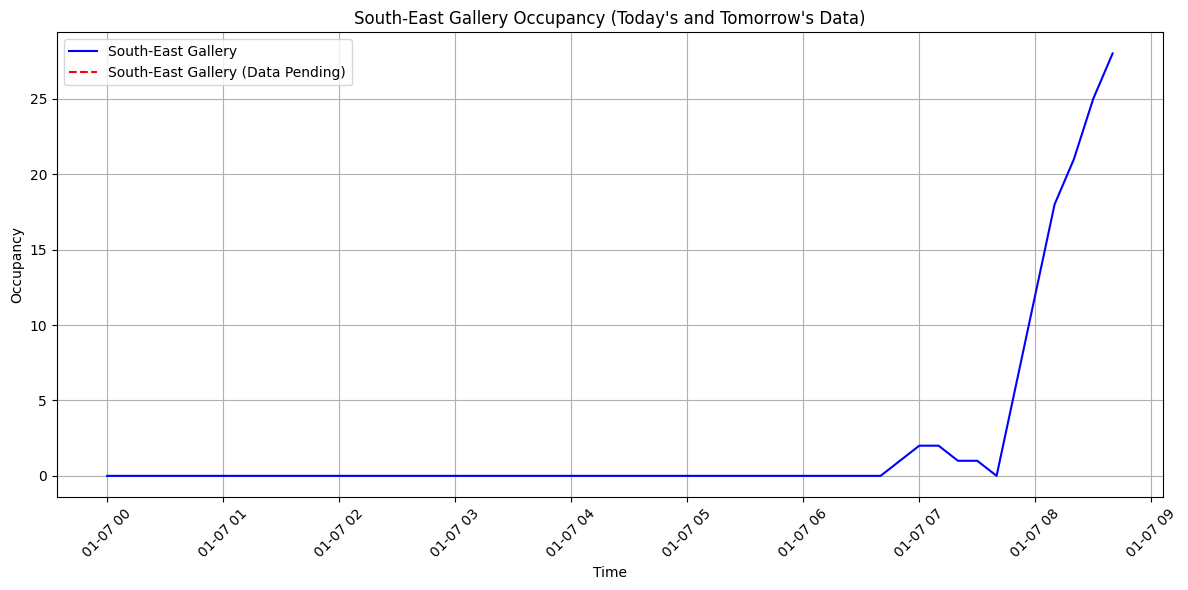

In [96]:
# Plot the data for today and tomorrow
plt.figure(figsize=(12, 6))
plt.plot(df_downloaded.index, df_downloaded['South-East Gallery'], label="South-East Gallery", color='blue')
plt.plot(df_null.index, df_null['South-East Gallery'], label="South-East Gallery (Data Pending)", color='red', linestyle='--')

plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
df_today_tomorrow

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton
2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
import requests

def get_detailed_weather_forecast(latitude, longitude):
    """
    Fetches a detailed weather forecast for the remainder of the current day and the next 24 hours,
    with data points every 10 minutes created manually from hourly data.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.

    Returns:
        pd.DataFrame: DataFrame containing the forecast data with 10-minute intervals.
    """
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m"],
        "forecast_days": 2,  # Ensures today and tomorrow are covered
        "timezone": "auto",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract hourly data
    hourly_data = data.get('hourly', {})

    if not hourly_data:
        raise ValueError("No hourly data available in the API response.")

    weather_df = pd.DataFrame(hourly_data)

    # Convert time to datetime format
    if "time" in weather_df.columns:
        weather_df["time"] = pd.to_datetime(weather_df["time"], errors="coerce")
    else:
        raise KeyError("The 'time' column is missing in the hourly weather data.")

    # Set 'time' as the index
    weather_df.set_index("time", inplace=True)

    # Create 10-minute intervals
    detailed_weather_data = []
    for i in range(len(weather_df) - 1):
        start_row = weather_df.iloc[i]
        end_row = weather_df.iloc[i + 1]
        time_start = weather_df.index[i]
        time_end = weather_df.index[i + 1]

        # Generate intermediate 10-minute data
        time_range = pd.date_range(time_start, time_end, periods=7)[1:]
        for t in time_range:
            interpolated_row = {
                "time": t,
                "temperature_2m": start_row["temperature_2m"] + (end_row["temperature_2m"] - start_row["temperature_2m"]) * (t - time_start) / (time_end - time_start),
                "precipitation": start_row["precipitation"] + (end_row["precipitation"] - start_row["precipitation"]) * (t - time_start) / (time_end - time_start),
                "wind_speed_10m": start_row["wind_speed_10m"] + (end_row["wind_speed_10m"] - start_row["wind_speed_10m"]) * (t - time_start) / (time_end - time_start),
                "wind_direction_10m": start_row["wind_direction_10m"] + (end_row["wind_direction_10m"] - start_row["wind_direction_10m"]) * (t - time_start) / (time_end - time_start),
            }
            detailed_weather_data.append(interpolated_row)

    # Convert to DataFrame
    detailed_weather_df = pd.DataFrame(detailed_weather_data)
    detailed_weather_df.set_index("time", inplace=True)

    # Debug outputs
    print("Index type:", detailed_weather_df.index.dtype)
    print("Columns:", detailed_weather_df.columns)

    return detailed_weather_df

# Parameters
latitude, longitude = 59.3293, 18.0686  # Stockholm coordinates

# Get weather data for today and tomorrow, interpolated to 10-minute intervals
weather_data = get_detailed_weather_forecast(latitude, longitude)

# Print the merged and interpolated weather data for today and tomorrow
weather_data



Index type: datetime64[ns]
Columns: Index(['temperature_2m', 'precipitation', 'wind_speed_10m',
       'wind_direction_10m'],
      dtype='object')


,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2025-01-07 00:10:00,0.800000,0.966667,27.450000,114.333333
2025-01-07 00:20:00,0.800000,0.933333,27.500000,113.666667
2025-01-07 00:30:00,0.800000,0.900000,27.550000,113.000000
2025-01-07 00:40:00,0.800000,0.866667,27.600000,112.333333
2025-01-07 00:50:00,0.800000,0.833333,27.650000,111.666667
...,...,...,...,...
2025-01-08 22:20:00,1.533333,0.066667,13.566667,242.333333
2025-01-08 22:30:00,1.500000,0.050000,14.050000,244.000000
2025-01-08 22:40:00,1.466667,0.033333,14.533333,245.666667


In [99]:
os.environ["HOPSWORKS_API_KEY"] = "pJymTzms8OtLxz9l.fj2klQnbFO3ZmkYrgeAGMEAKguhmEYo3wcmb6rDXd3NRJu1Xv9WNDGAUj4TFgh3Z"
project = hopsworks.login()
fs = project.get_feature_store()

# Get or create feature group
feature_group = fs.get_or_create_feature_group(
    name="kth_academic_year",
    version=1,
    description="Weather data history",
    primary_key=['id'],
    event_time=['date'],  # Ensure this matches the DataFrame
    online_enabled=True
)

2025-01-07 10:03:56,627 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 10:03:56,633 INFO: Initializing external client
2025-01-07 10:03:56,635 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 10:03:57,934 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1205426


In [100]:
# Read data from the feature store
df_calendar = feature_group.read()

# Reset the index to make 'date' a column
df_calendar.reset_index(inplace=True)

# Rename 'date' to 'time' and other columns to match the desired format
df_calendar.rename(
    columns={
        'date': 'time',
        'year': 'Year',
        'day_of_year': 'Day of Year',
        'day_of_week': 'Day of Week',
        'days_until_exam': 'Days Until Exam',
        'event': 'Event'
    },
    inplace=True
)

# Ensure 'time' is in datetime64[us] format, removing timezone information
df_calendar['time'] = pd.to_datetime(df_calendar['time'], format='%Y-%m-%d')
df_calendar['time'] = df_calendar['time'].dt.tz_localize(None)  # Remove timezone info

# Verify the structure
df_calendar.info()

# Display the first few rows to confirm
print(df_calendar.head())
df_calendar_expanded = df_calendar.copy()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            581 non-null    int64         
 1   id               581 non-null    int64         
 2   time             581 non-null    datetime64[us]
 3   Year             581 non-null    int64         
 4   Day of Year      581 non-null    int64         
 5   Day of Week      581 non-null    int64         
 6   Days Until Exam  581 non-null    int64         
 7   Event            581 non-null    object        
dtypes: datetime64[us](1), int64(6), object(1)
memory usage: 36.4+ KB
   index   id       time  Year  Day of Year  Day of Week  Days Until Exam  \
0      0  225 2026-04-07  2026           97            2               48   
1      1    8 2025-09-02  2025          245            2

In [101]:
## Step 2: Load the academic calendar dataset
#repo_name_calendar = "andreitut/kth-academic-scraper"
#hf_dataset_calendar = load_dataset(repo_name_calendar)
#
## Convert the calendar dataset to a DataFrame
#df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
#df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])
#
## Expand the calendar dataset to match the minute-level resolution
#df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
#df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
#df_calendar_expanded.info()

In [102]:
# Get or create feature group
feature_group = fs.get_or_create_feature_group(
    name="kth_opening_hour",
    version=1,
    description="Feature group containing store opening and closing hours.",
    primary_key=['id'],
    event_time=['date'],
    online_enabled=True
)

# Load existing data
df_opening = feature_group.read()
df_opening = df_opening.sort_values(by='date', ascending=True)
df_opening

if 'id' in df_opening.columns:
    df_opening.set_index('id', inplace=True)
    
# Remove timezone information
df_opening['date'] = df_opening['date'].dt.tz_localize(None)
df_opening.set_index('date', inplace=True)

df_opening.tail()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


,day,opening_hour,closing_hour,is_open
date,,,,
2025-01-29,Friday,8,19,1
2025-01-30,Saturday,10,16,1
2025-01-31,Sunday,0,0,0
2025-02-01,Monday,8,21,1
2025-02-02,Tuesday,8,21,1


### 2.2 Merge the Data


In [103]:
df_null

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton
2025-01-07 08:50:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 09:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 09:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
print(df_calendar_expanded)

     index   id       time  Year  Day of Year  Day of Week  Days Until Exam  \
0        0  225 2026-04-07  2026           97            2               48   
1        1    8 2025-09-02  2025          245            2               44   
2        2  160 2026-02-01  2026           32            7               33   
3        3   42 2025-10-06  2025          279            1               10   
4        4   74 2025-11-07  2025          311            5               59   
..     ...  ...        ...   ...          ...          ...              ...   
576    576   13 2024-08-14  2024          227            3                0   
577    577  159 2025-01-07  2025            7            2                0   
578    578  170 2025-01-18  2025           18            6                0   
579    579  202 2025-02-19  2025           50            3                0   
580    580   31 2024-09-01  2024          245            7                0   

       Event  
0    Holiday  
1     Normal  
2     

In [105]:
# Convert both time columns to the same datetime format
df_null.index = pd.to_datetime(df_null.index)  # Convert index to datetime if needed
df_calendar_expanded['time'] = pd.to_datetime(df_calendar_expanded['time'])  # Convert 'time' to datetime

# Ensure they are of the same resolution, e.g., nanoseconds
df_null.index = df_null.index.astype('datetime64[ns]')
df_calendar_expanded['time'] = df_calendar_expanded['time'].astype('datetime64[ns]')

# Perform the asof merge
merged_seating_calendar = pd.merge_asof(
    df_null.sort_index(),
    df_calendar_expanded.sort_values('time'),
    left_index=True,
    right_on='time'
)

# Visualize the merged data
print("Step 3: Merged seating data with academic calendar")
merged_seating_calendar


Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,index,id,time,Year,Day of Year,Day of Week,Days Until Exam,Event
2025-01-07 08:50:00,NaN,NaN,NaN,NaN,NaN,NaN,577,159,2025-01-07,2025,7,2,0,Holiday
2025-01-07 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,577,159,2025-01-07,2025,7,2,0,Holiday
2025-01-07 09:10:00,NaN,NaN,NaN,NaN,NaN,NaN,577,159,2025-01-07,2025,7,2,0,Holiday
2025-01-07 09:20:00,NaN,NaN,NaN,NaN,NaN,NaN,577,159,2025-01-07,2025,7,2,0,Holiday
2025-01-07 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,577,159,2025-01-07,2025,7,2,0,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,561,160,2025-01-08,2025,8,3,0,Holiday
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,561,160,2025-01-08,2025,8,3,0,Holiday
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,561,160,2025-01-08,2025,8,3,0,Holiday
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,561,160,2025-01-08,2025,8,3,0,Holiday


In [106]:
merged_seating_calendar.drop(['index', 'id'], axis = 1, inplace = True)

In [107]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    weather_data.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
#merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,time,Year,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN


In [108]:
df_opening.tail()

,day,opening_hour,closing_hour,is_open
date,,,,
2025-01-29,Friday,8,19,1
2025-01-30,Saturday,10,16,1
2025-01-31,Sunday,0,0,0
2025-02-01,Monday,8,21,1
2025-02-02,Tuesday,8,21,1


In [109]:
merge_seat_academic_weather.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,time,Year,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN
2025-01-08 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN


In [110]:
df_opening.tail()

,day,opening_hour,closing_hour,is_open
date,,,,
2025-01-29,Friday,8,19,1
2025-01-30,Saturday,10,16,1
2025-01-31,Sunday,0,0,0
2025-02-01,Monday,8,21,1
2025-02-02,Tuesday,8,21,1


In [111]:
# Convert both to exactly the same datetime type
merge_seat_academic_weather['time'] = pd.to_datetime(merge_seat_academic_weather['time']).astype('datetime64[ns]')
df_opening.index = pd.to_datetime(df_opening.index).astype('datetime64[ns]')

# Sort both DataFrames
merge_seat_academic_weather = merge_seat_academic_weather.sort_values('time')
df_opening = df_opening.sort_index()

# Perform the asof merge
merged_final = pd.merge_asof(
    merge_seat_academic_weather,
    df_opening,
    left_on='time',
    right_index=True,
    direction='backward'
)

# View the result
merged_final.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,time,Year,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
2025-01-08 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.500000,0.000000,21.600000,182.000000,Wednesday,8,21,1
2025-01-08 08:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.466667,0.016667,21.366667,181.500000,Wednesday,8,21,1
2025-01-08 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.433333,0.033333,21.133333,181.000000,Wednesday,8,21,1
2025-01-08 11:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.400000,0.833333,14.733333,175.333333,Wednesday,8,21,1
2025-01-08 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,NaN,NaN,NaN,NaN,Wednesday,8,21,1


In [112]:
# 4. Remove the last 10 entries if needed
df_resampled = merged_final.copy()
df_resampled = df_resampled[:-10]
df_resampled.to_csv('merged_future.csv')
df_resampled.tail()

,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,time,Year,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
2025-01-08 06:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.433333,0.0,23.533333,183.333333,Wednesday,8,21,1
2025-01-08 06:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.450000,0.0,23.400000,183.500000,Wednesday,8,21,1
2025-01-08 06:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.466667,0.0,23.266667,183.666667,Wednesday,8,21,1
2025-01-08 06:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.483333,0.0,23.133333,183.833333,Wednesday,8,21,1
2025-01-08 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-08,2025,8,3,0,Holiday,2.500000,0.0,23.000000,184.000000,Wednesday,8,21,1


## 2.3 Inference


In [113]:
from huggingface_hub import login # Import the login function
from huggingface_hub import hf_hub_download, HfApi

In [114]:
def load_models_from_huggingface(locations, repo_name, token):
    """
    Load models from Hugging Face.

    Args:
        locations: List of locations
        repo_name: Name of the Hugging Face repository
        token: Hugging Face API token
    Returns:
        dict: Dictionary containing loaded models
    """
    login(token=token)
    loaded_models = {}

    for location in locations:
        filename = f"xgboost_model_{location.replace(' ', '_')}.joblib"

        # Download the model file
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=filename,
            token=token
        )

        # Load the model
        model = joblib.load(model_path)
        loaded_models[location] = {'model': model}
        print(f"Model for {location} loaded successfully")

    return loaded_models

Model for KTH Library loaded successfully
Model for South-East Gallery loaded successfully
Model for North Gallery loaded successfully
Model for South Gallery loaded successfully
Model for Ångdomen loaded successfully
Model for Newton loaded successfully


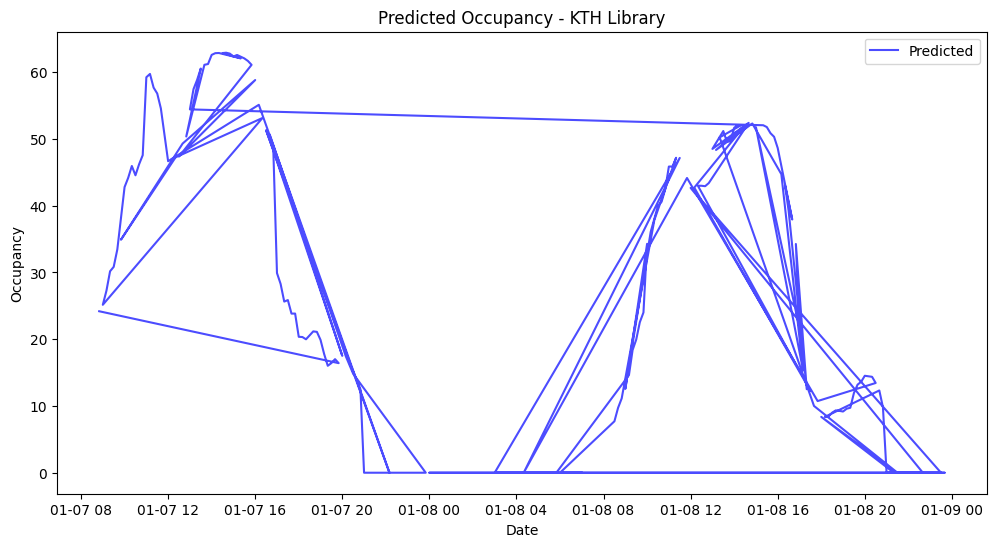

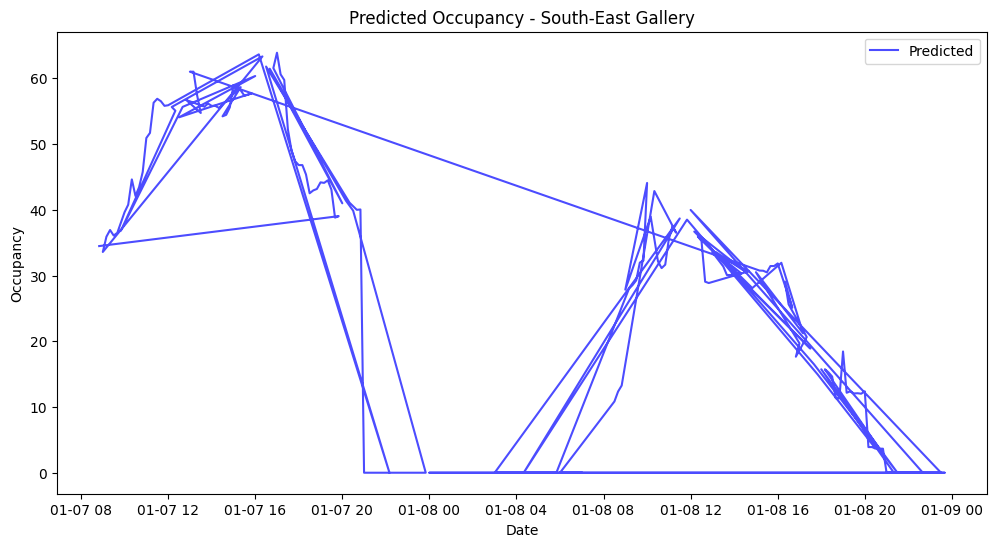

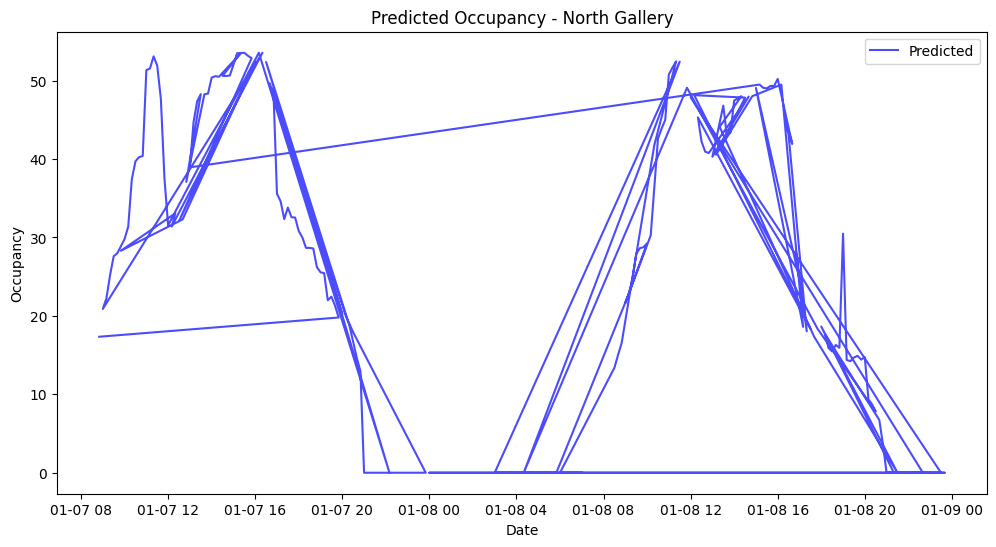

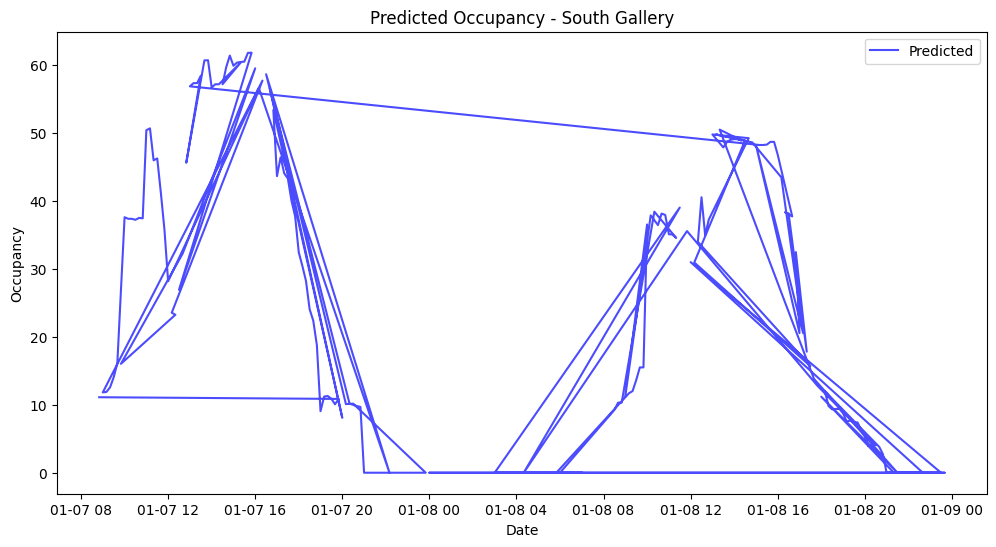

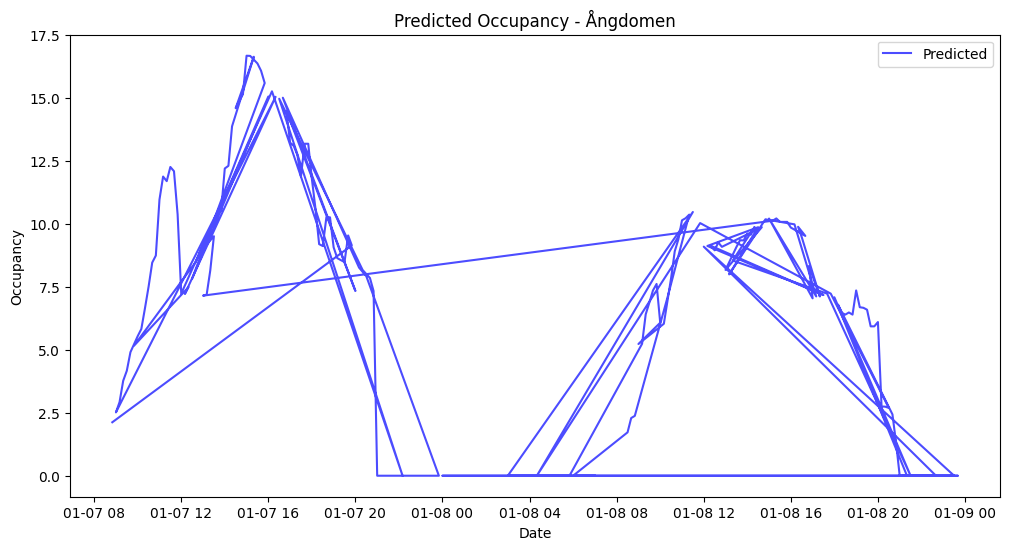

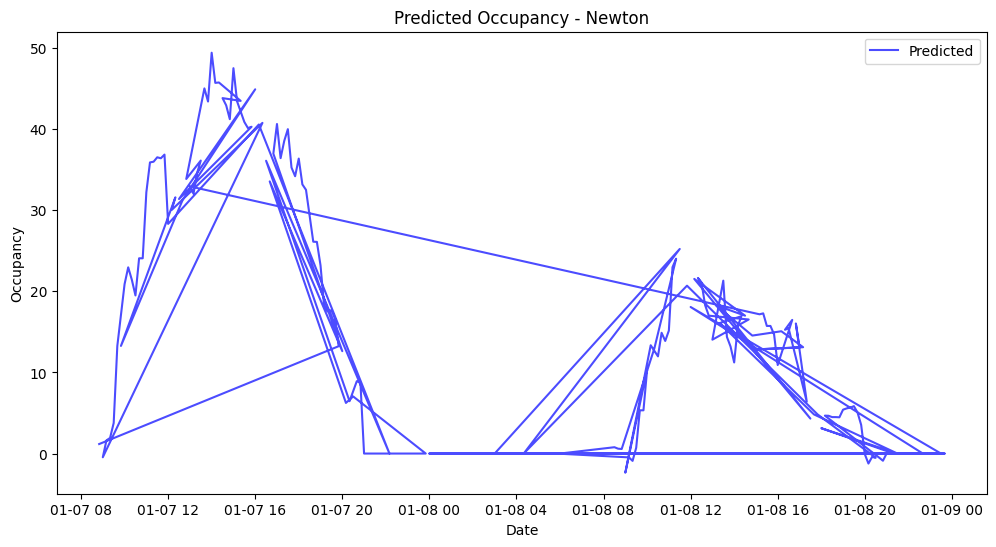

Model for KTH Library loaded successfully
Model for South-East Gallery loaded successfully
Model for North Gallery loaded successfully
Model for South Gallery loaded successfully
Model for Ångdomen loaded successfully
Model for Newton loaded successfully


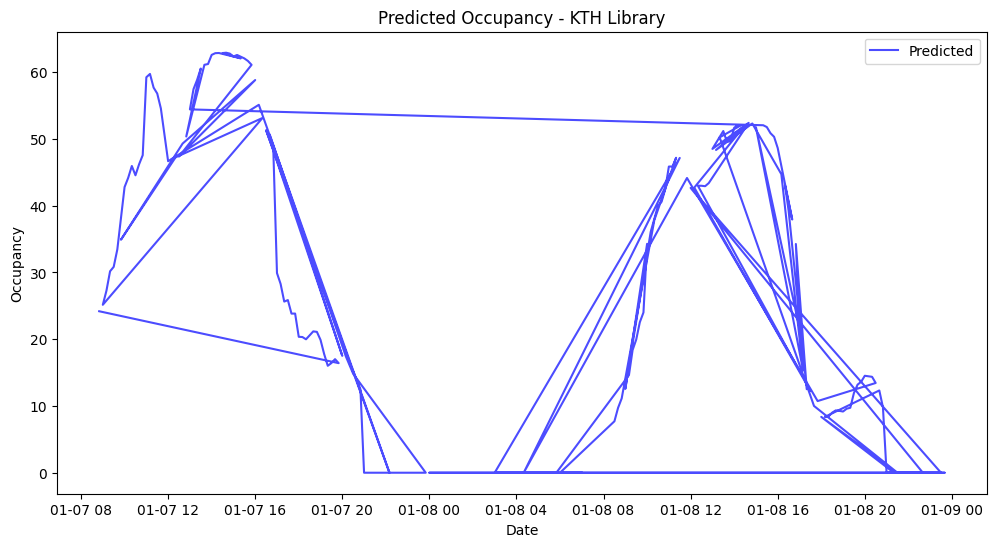

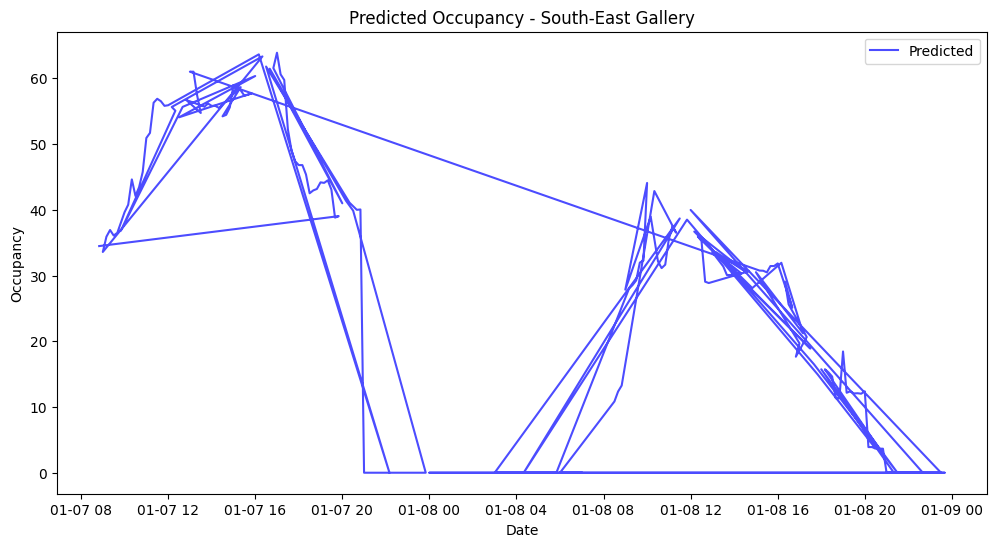

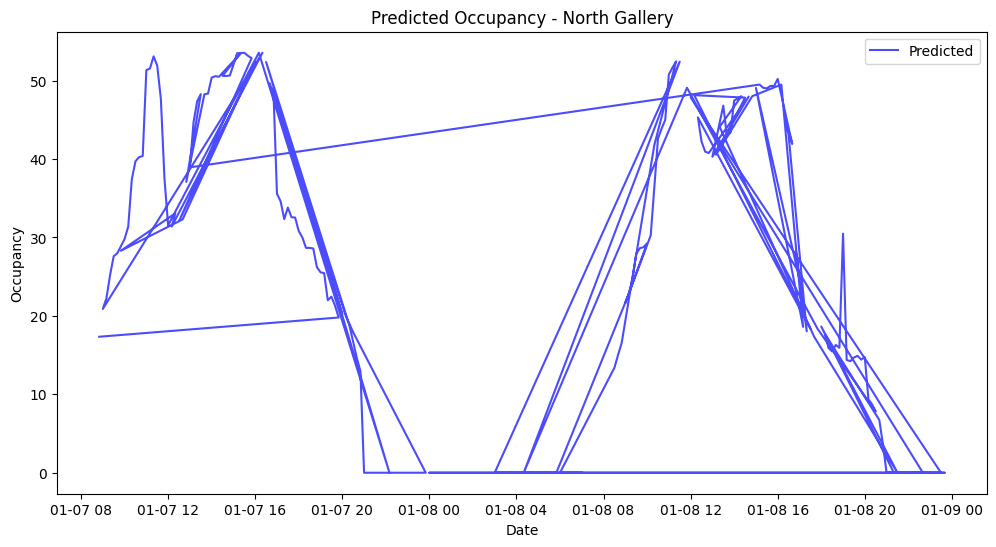

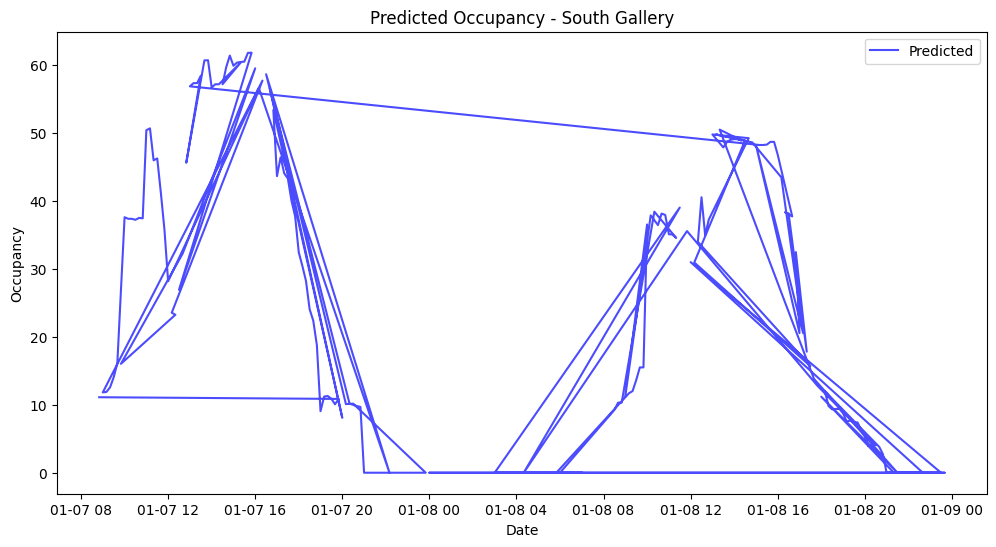

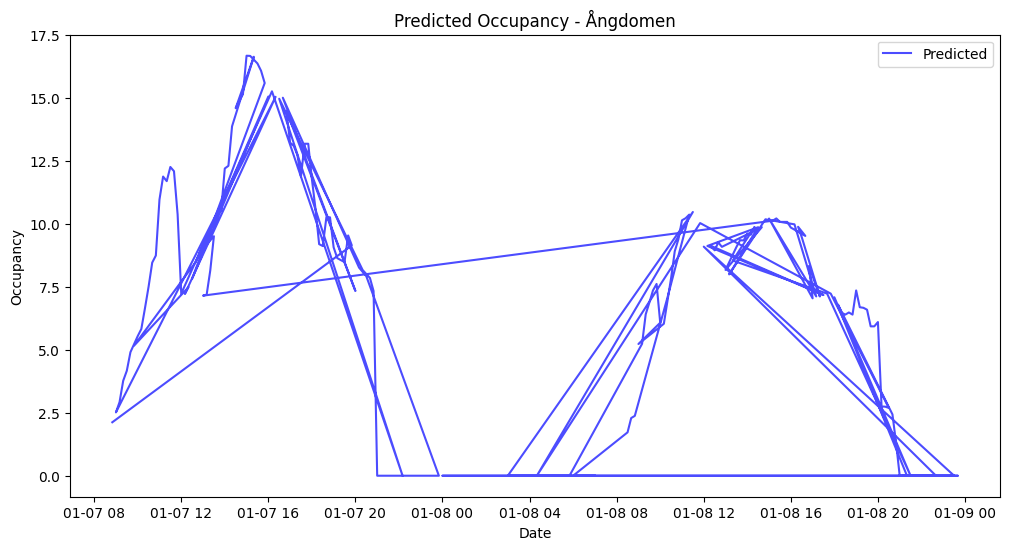

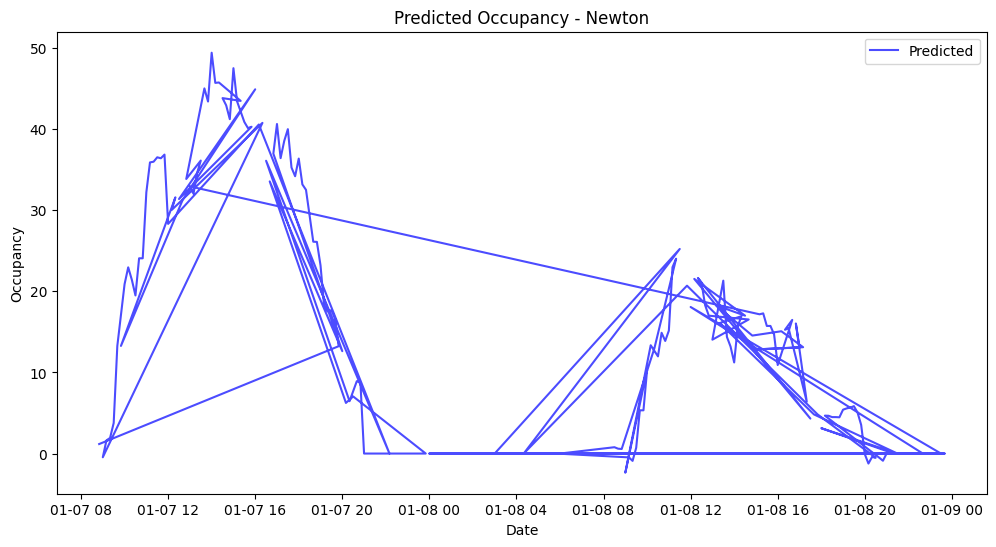

In [115]:
from huggingface_hub import login, hf_hub_download
import joblib
from utils import predict_future
login(HUGGINGFACE_TOKEN)

future_df = df_resampled.copy()
future_df = preprocess_raw_data(future_df)
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery',
       'Ångdomen', 'Newton']  # Add all your locations
# Load models from Hugging Face

repo_name = "davnas/library_model"
loaded_models = load_models_from_huggingface(locations, repo_name, HUGGINGFACE_TOKEN)

# Use loaded models for prediction
future_predictions = predict_future(loaded_models, future_df)
future_df = df_resampled.copy()
future_df = preprocess_raw_data(future_df)
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery',
       'Ångdomen', 'Newton']  # Add all your locations
# Load models from Hugging Face

repo_name = "davnas/library_model"
loaded_models = load_models_from_huggingface(locations, repo_name, HUGGINGFACE_TOKEN)

# Use loaded models for prediction
future_predictions = predict_future(loaded_models, future_df)

In [116]:
from utils import predict_and_format
# Make predictions and format them
predictions_df = predict_and_format(loaded_models, future_df)

# View the results
print("Predictions shape:", predictions_df.shape)
print("\nFirst few predictions:")
print(predictions_df.head())


Predictions shape: (225, 6)

First few predictions:
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-07 08:50:00        24.18           34.480000      17.340000   
2025-01-07 09:00:00        25.15           33.580002      20.889999   
2025-01-07 09:10:00        27.25           35.910000      22.250000   
2025-01-07 09:20:00        30.17           36.930000      25.190001   
2025-01-07 09:30:00        30.83           36.080002      27.610001   

                     South Gallery  Ångdomen  Newton  
2025-01-07 08:50:00          11.11      2.12    1.17  
2025-01-07 09:00:00          11.82      2.52   -0.46  
2025-01-07 09:10:00          11.89      2.93    1.62  
2025-01-07 09:20:00          12.57      3.77    1.92  
2025-01-07 09:30:00          14.04      4.17    3.77  


In [117]:
# Convert columns to integers, handling potential errors
for col in predictions_df.columns:
    try:
        predictions_df[col] = predictions_df[col].astype(int)
    except ValueError:
        print(f"Warning: Could not convert column '{col}' to integer type.  Values might not be purely numeric.")
        # Handle the non-numeric values appropriately (e.g., fillna, replace with a default)
        predictions_df[col] = predictions_df[col].fillna(0).astype(int) #Example: Fill NaN with 0 then convert

In [118]:
predictions_df

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2025-01-07 08:50:00,24,34,17,11,2,1
2025-01-07 09:00:00,25,33,20,11,2,0
2025-01-07 09:10:00,27,35,22,11,2,1
2025-01-07 09:20:00,30,36,25,12,3,1
2025-01-07 09:30:00,30,36,27,14,4,3
...,...,...,...,...,...,...
2025-01-08 23:00:00,0,0,0,0,0,0
2025-01-08 23:10:00,0,0,0,0,0,0
2025-01-08 23:20:00,0,0,0,0,0,0
2025-01-08 23:30:00,0,0,0,0,0,0


## 2.4 Combining the past and future

In [119]:
df_past = df_downloaded.copy()
df_past['prediction'] = 0
df_past.reset_index(inplace=True)

df_past

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,prediction
0,2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2025-01-07 00:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0
6,2025-01-07 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
7,2025-01-07 01:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
8,2025-01-07 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
9,2025-01-07 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0


In [120]:
df_future = predictions_df.copy()
df_future['prediction'] = 1
df_future.reset_index(inplace=True)


In [121]:
df_full = pd.concat([df_past, df_future])
df_full
df_full

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Angdomen,Newton,prediction,Ångdomen
0,2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
1,2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
2,2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
3,2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
4,2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...
220,2025-01-08 23:00:00,0.0,0.0,0.0,0.0,NaN,0.0,1,0.0
221,2025-01-08 23:10:00,0.0,0.0,0.0,0.0,NaN,0.0,1,0.0
222,2025-01-08 23:20:00,0.0,0.0,0.0,0.0,NaN,0.0,1,0.0
223,2025-01-08 23:30:00,0.0,0.0,0.0,0.0,NaN,0.0,1,0.0


In [122]:
df_full = df_full.rename(columns={'index': 'ds'})
df_full
df_full.to_csv('7_01_predLog.csv')

## 2.5 Plotting

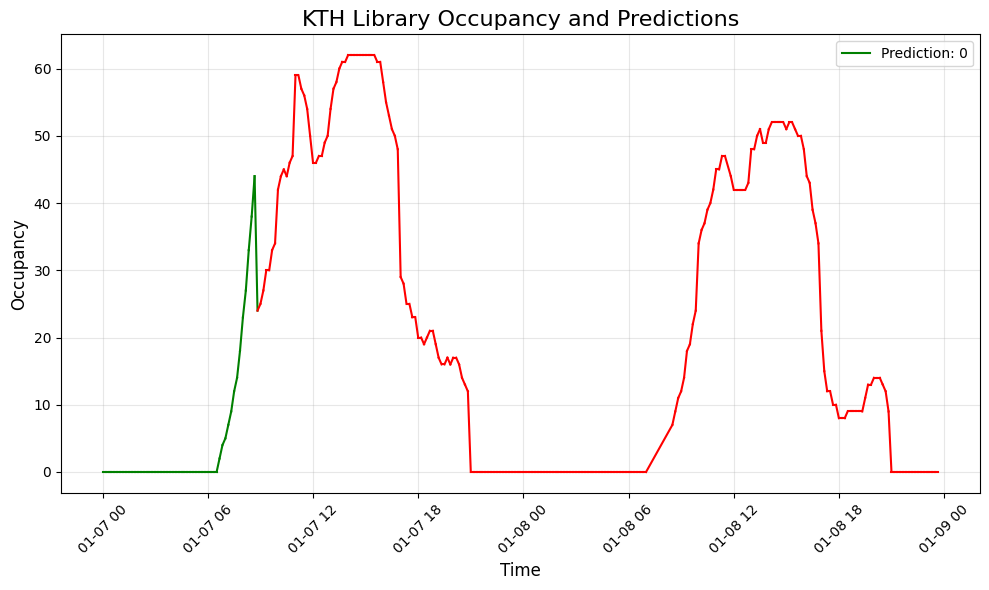

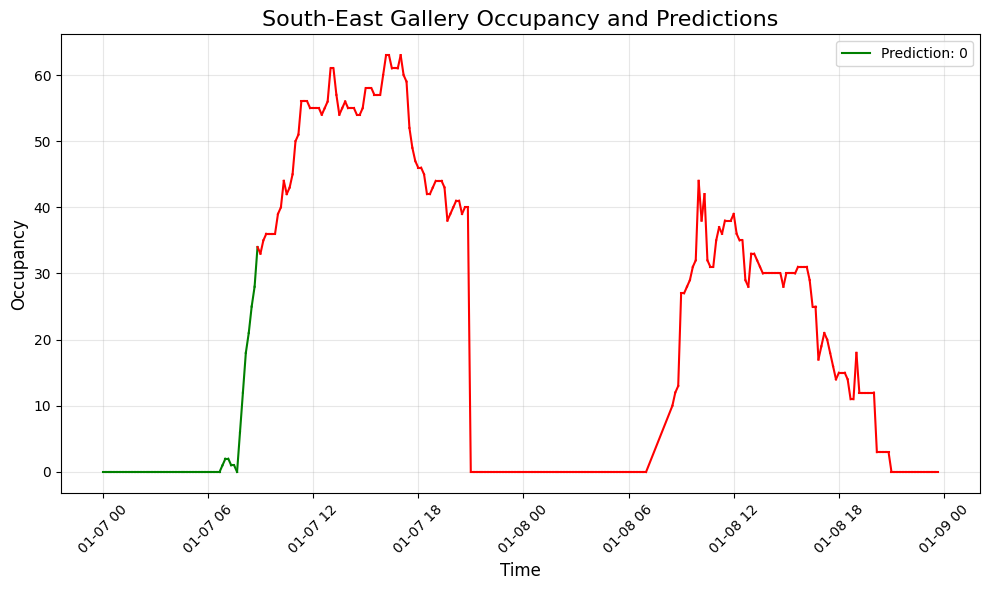

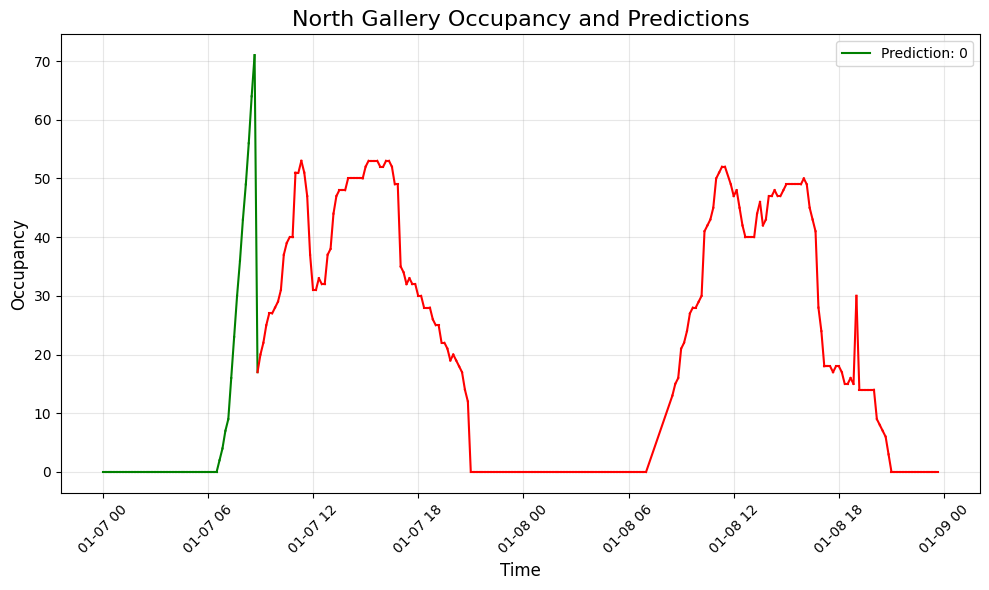

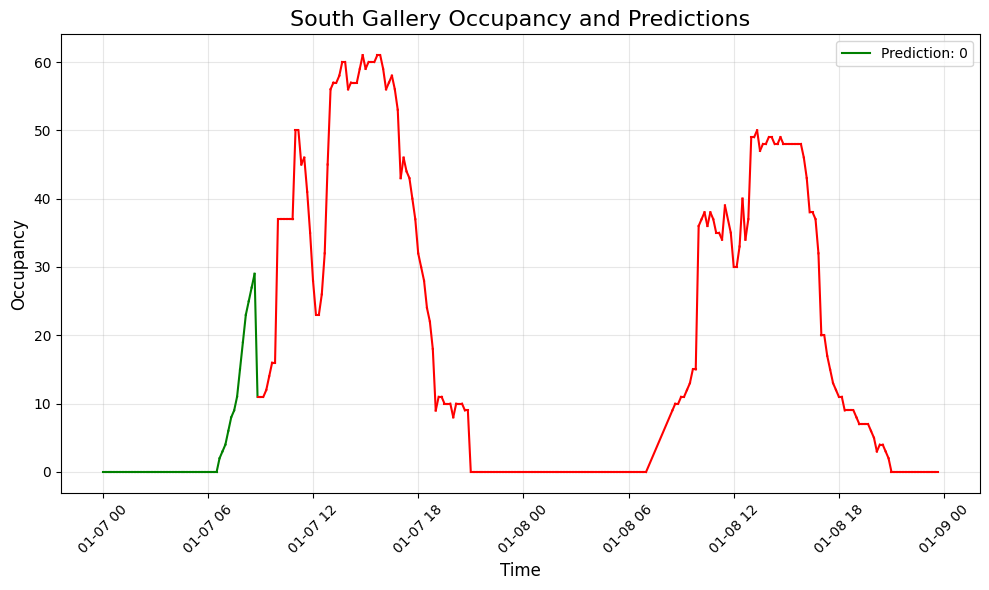

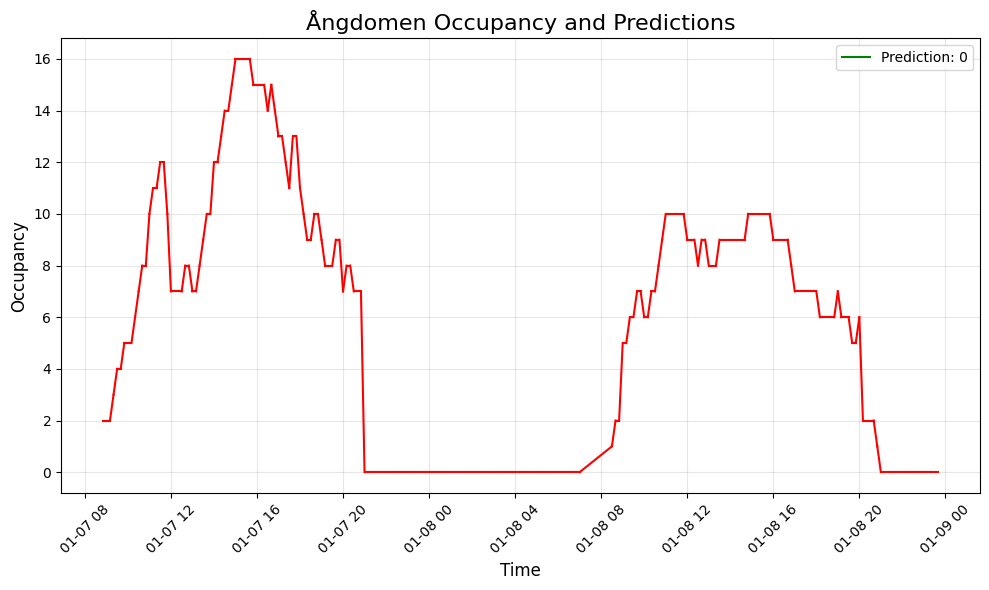

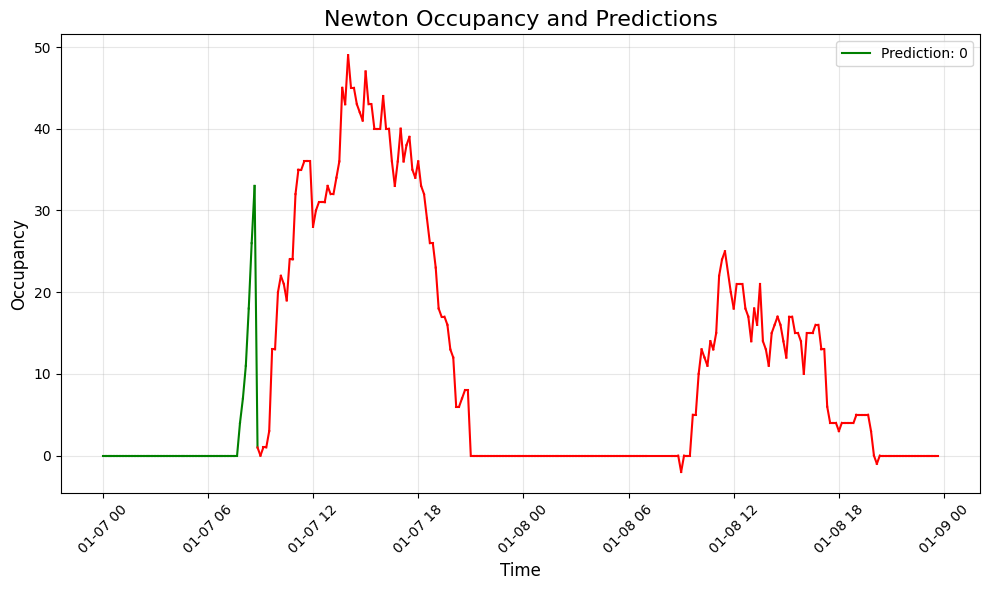

In [124]:
# Ensure the 'ds' column exists and is datetime
if 'ds' not in df_full.columns:
    raise KeyError("'ds' column is missing from the DataFrame.")

# Plot each location in a separate figure
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']

for location in locations:
    plt.figure(figsize=(10, 6))

    # Iterate through the DataFrame rows and plot segments based on prediction
    for i in range(len(df_full) - 1):
        color = 'green' if df_full['prediction'].iloc[i] == 0 else 'red'
        plt.plot(
            df_full['ds'].iloc[i:i+2],  # X-axis
            df_full[location].iloc[i:i+2],  # Y-axis
            color=color, label=f'Prediction: {df_full["prediction"].iloc[i]}' if i == 0 else ""
        )

    plt.title(f"{location} Occupancy and Predictions", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Occupancy", fontsize=12)
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show each plot
    plt.show()

## 2.6 Pushing


In [39]:
import pandas as pd
from datetime import timedelta

# Ensure 'ds' is localized correctly
if df_full['ds'].dt.tz is None:
    df_full['ds'] = df_full['ds'].dt.tz_localize('UTC')  # Localize as UTC

# Remove timezone if you want naive timestamps
df_full['ds'] = df_full['ds'].dt.tz_convert(None)


In [40]:
# Get today's normalized date
today_date = pd.Timestamp.now().normalize()

# Filter for today's data
df_today = df_full[(df_full['ds'] >= today_date) & (df_full['ds'] < today_date + timedelta(days=1))]

# Resample as needed
df_today_resampled = (
    df_today.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = today_date + timedelta(hours=7, minutes=30)
end_time = today_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_today_resampled = (
    df_today_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_today_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,2025-01-03 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,2025-01-03 08:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3,2025-01-03 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,2025-01-03 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
5,2025-01-03 10:00:00,11.666667,14.000000,8.000000,13.333333,1.333333,16.000000,1.0
6,2025-01-03 10:30:00,18.666667,17.666667,15.000000,10.333333,2.333333,20.666667,1.0
7,2025-01-03 11:00:00,20.333333,19.333333,18.333333,17.666667,2.666667,19.000000,1.0
8,2025-01-03 11:30:00,18.666667,19.000000,17.666667,15.000000,2.000000,24.000000,1.0
9,2025-01-03 12:00:00,19.000000,15.666667,15.333333,13.666667,2.000000,17.333333,1.0


In [41]:
# Get tomorrow's normalized date
tomorrow_date = (pd.Timestamp.now() + timedelta(days=1)).normalize()

# Filter for tomorrow's data
df_tomorrow = df_full[(df_full['ds'] >= tomorrow_date) & (df_full['ds'] < tomorrow_date + timedelta(days=1))]

# Resample as needed
df_tomorrow_resampled = (
    df_tomorrow.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = tomorrow_date + timedelta(hours=7, minutes=30)
end_time = tomorrow_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_tomorrow_resampled = (
    df_tomorrow_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_tomorrow_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-04 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2025-01-04 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2025-01-04 08:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2025-01-04 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2025-01-04 09:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2025-01-04 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2025-01-04 10:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2025-01-04 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,2025-01-04 11:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2025-01-04 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Convert all occupancy values to integers
occupancy_columns = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']
df_today_resampled[occupancy_columns] = df_today_resampled[occupancy_columns].fillna(0).astype(int)
df_tomorrow_resampled[occupancy_columns] = df_tomorrow_resampled[occupancy_columns].fillna(0).astype(int)

In [43]:
df_tomorrow_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-04 07:30:00,0,0,0,0,0,0,1.0
1,2025-01-04 08:00:00,0,0,0,0,0,0,1.0
2,2025-01-04 08:30:00,0,0,0,0,0,0,1.0
3,2025-01-04 09:00:00,0,0,0,0,0,0,1.0
4,2025-01-04 09:30:00,0,0,0,0,0,0,1.0
5,2025-01-04 10:00:00,0,0,0,0,0,0,1.0
6,2025-01-04 10:30:00,0,0,0,0,0,0,1.0
7,2025-01-04 11:00:00,0,0,0,0,0,0,1.0
8,2025-01-04 11:30:00,0,0,0,0,0,0,1.0
9,2025-01-04 12:00:00,0,0,0,0,0,0,1.0


In [44]:
from datetime import datetime, timedelta # Import datetime and timedelta

# Add the required columns for CommitTime and Time
current_time = datetime.now()

commit_time = (current_time + timedelta(hours=1)).strftime("%Y-%m-%d %H:%M:%S")
df_today_resampled['CommitTime'] = commit_time
df_tomorrow_resampled['CommitTime'] = commit_time

df_today_resampled['Time'] = df_today_resampled['ds'].dt.strftime('%H:%M')
df_tomorrow_resampled['Time'] = df_tomorrow_resampled['ds'].dt.strftime('%H:%M')

# Rename columns to match the required format
df_today_resampled = df_today_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

df_tomorrow_resampled = df_tomorrow_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

# Reorder columns
df_today_resampled = df_today_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]

df_tomorrow_resampled = df_tomorrow_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]


In [45]:
#df_tomorrow_resampled

In [46]:
#df_today_resampled

In [47]:
# Save to CSV
df_tomorrow_resampled.to_csv('tomorrow_resampled.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-03 02:23:26  19:30               0                    0   
25  2025-01-03 02:23:26  20:00               0                    0   
26  2025-01-03 02:23:26  20:30               0                    0   
27  2025-01-03 02:23:26  21:00               0                    0   
28  2025-01-03 02:23:26  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24                0                0                   0                 0  
25                0                0                   0                 0  
26                0                0                   0                 0  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [48]:
# Save to CSV
df_today_resampled.to_csv('occupancy_today.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-03 02:23:26  19:30               0                    0   
25  2025-01-03 02:23:26  20:00               0                    0   
26  2025-01-03 02:23:26  20:30               0                    0   
27  2025-01-03 02:23:26  21:00               0                    0   
28  2025-01-03 02:23:26  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24                0                0                   0                 0  
25                0                0                   0                 0  
26                0                0                   0                 0  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [49]:
import pandas as pd


csv_file_path = "occupancy_today.csv"
csv_file_path_1 = "tomorrow_resampled.csv"

from huggingface_hub import HfApi, HfFolder

# Hugging Face token and repository details
repo_name = "davnas/library-occupancy"  # Replace with your repository name
#csv_file_path = "data.csv"  # Replace with your CSV file path

# Authenticate using the token
HfFolder.save_token(HUGGINGFACE_TOKEN)
api = HfApi()

# Upload the CSV file
api.upload_file(
    path_or_fileobj=csv_file_path,
    path_in_repo="data_2.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

api.upload_file(
    path_or_fileobj=csv_file_path_1,
    path_in_repo="forecast_tomorrow.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

print(f"CSV file successfully uploaded to Hugging Face repository: {repo_name}")



CSV file successfully uploaded to Hugging Face repository: davnas/library-occupancy
